In [154]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
#code for making artificial dataset
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGU', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
        seqs.append(('>ID%d'%counter,total_seq))
        counter += 1
    return motives, seqs

In [156]:
from eden.motif import SequenceMotif
#help(SequenceMotif)

# Experimental Setup

In [157]:
#setup parameters
alphabet='ACGU'
semi_len=9
motives=['A'*semi_len+'C'*semi_len,
         'C'*semi_len+'A'*semi_len,
         'A'*semi_len+'U'*semi_len,
         'U'*semi_len+'A'*semi_len]
sequence_length=160
n_sequences=200
p=0.2

#make dataset
motives, seqs = make_artificial_dataset(alphabet=alphabet,
                                        motives=motives,
                                        sequence_length=sequence_length,
                                        n_sequences=n_sequences,
                                        p=p,
                                        random_state=8)

In [158]:
#display
print 'Motives and sample of their perturbed variants:'
alphabet_list=[c for c in alphabet]
for motif in motives: 
    print
    print 'true motif:', motif, ' noisy: ',
    for i in range(4):
        print perturb(motif,alphabet_list,p=p),

Motives and sample of their perturbed variants:

true motif: AAAAAAAAACCCCCCCCC  noisy:  AAAAAAAAACCCACCCCC AAAAAAAACCCCCACCCA AAAAGAAAUCCCCCACAC AAAUAGACAGACGCCGGC
true motif: CCCCCCCCCAAAAAAAAA  noisy:  CCCCCCCCCUAAAAAAAG CCCCCCCCCACUACAAAG CCCCCCCUCAAAAAAAAG CCCCCCCCCAGAGAAAAA
true motif: AAAAAAAAAUUUUUUUUU  noisy:  AAAUGAAAAUUUUUUUUU ACUAAAAAUUUUUAUUUU AAAUAACAAGGUUCGUAU AAAAAAAAAUUUUUUUUU
true motif: UUUUUUUUUAAAAAAAAA  noisy:  UUUUUUUUUAAAGAAAAA UUUUUUUUUAAAAAAAUA UUUUUUAUGAAACAUCAA AGUUUUUUUAAAAUAAAA


In [159]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [160]:
%%time
from sklearn.cluster import Birch
ca = Birch(threshold=0.01, n_clusters=len(motives), branching_factor=50)

from eden.motif import SequenceMotif
seqmot = SequenceMotif(complexity=5, nbits=14, negative_ratio=3,
                       min_subarray_size=len(motives[0])-2, max_subarray_size=len(motives[0])+2, 
                       clustering_algorithm=ca, n_jobs=1)
seqmot.fit(seqs)

Positive data: Instances: 200 ; Features: 16385 with an avg of 5068 features per instance
Negative data: Instances: 600 ; Features: 16385 with an avg of 5197 features per instance
Elapsed time: 59.2 secs
model induction: 200 positive instances 60 s
motives extraction: 245 motives in 23s
motives clustering: 4 clusters in 1s
after filtering: 239 motives 4 clusters in 0s
motif model construction in 0s
updated motif counts in 0s
CPU times: user 1min 25s, sys: 1.71 s, total: 1min 27s
Wall time: 1min 25s


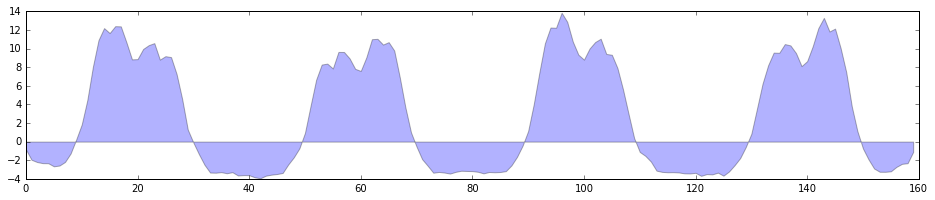

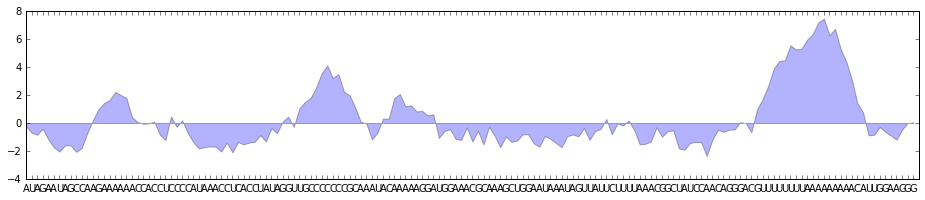

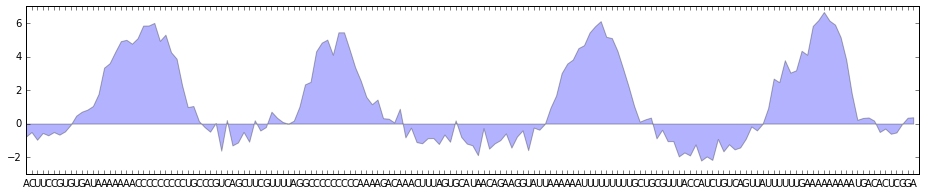

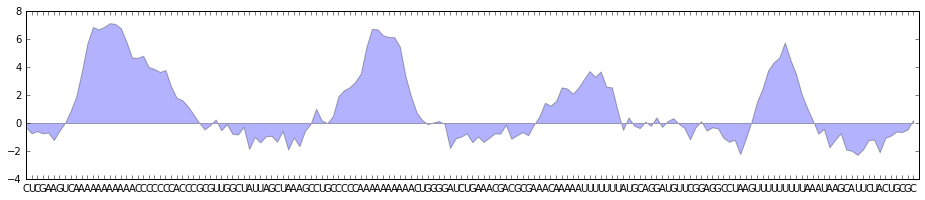

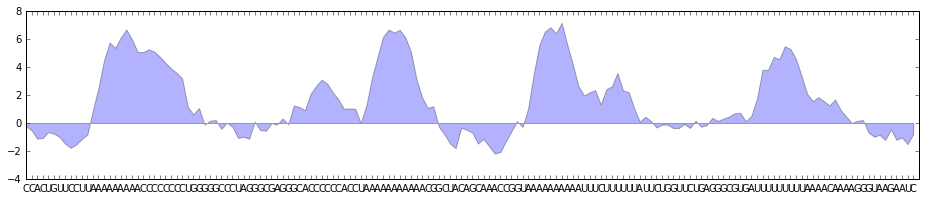

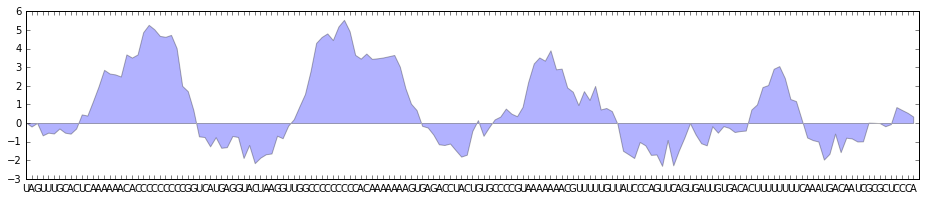

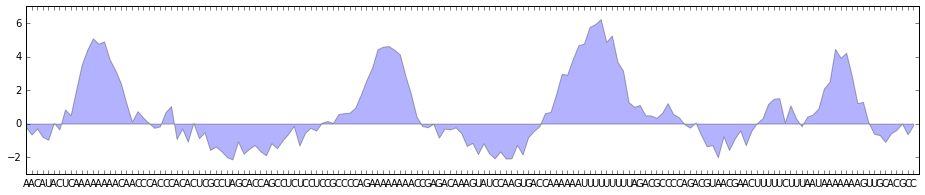

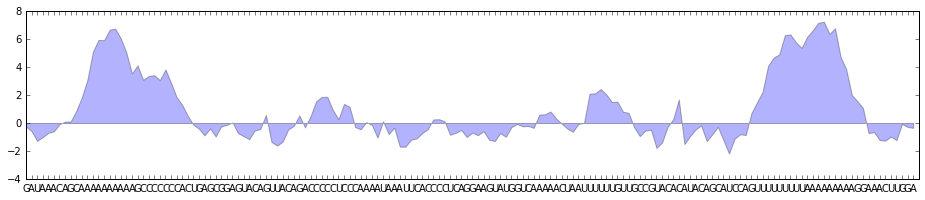

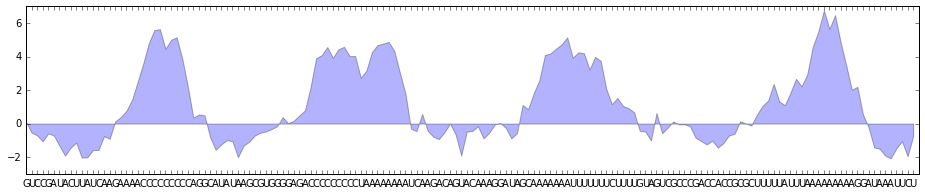

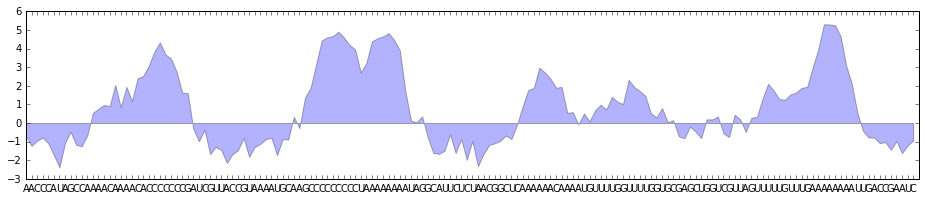

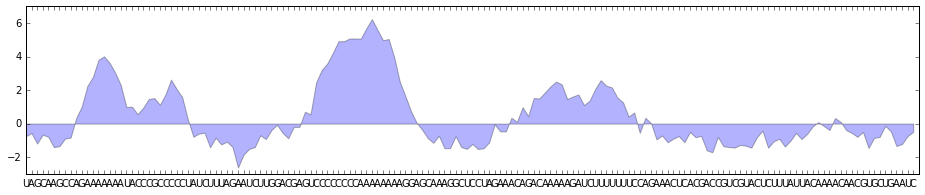

In [161]:
% matplotlib inline
import pylab as plt 
import numpy as np
sig = np.zeros(sequence_length)
for seq, score in seqmot.importances:
    sig += np.array(score)
sig /= float(len(seqmot.importances))
sig *= len(motives)
plt.figure(figsize=(16,3))
plt.fill_between(range(len(sig)), 0, sig, alpha=0.3)
plt.show()

print
print

for seq, score in seqmot.importances[:10]:
    plt.figure(figsize=(16,3))
    plt.fill_between(range(len(score)), 0, score, alpha=0.3)
    plt.xticks(range(len(score)), seq)
    plt.show()

Cluster id:0


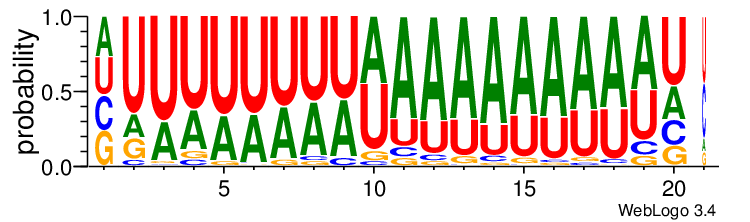

Cluster id:1


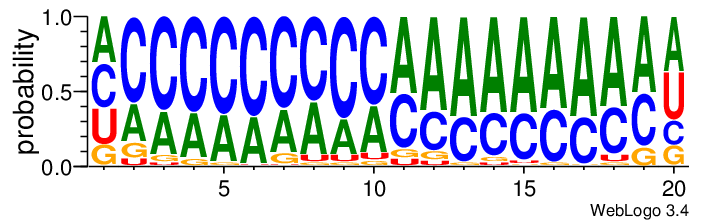

Cluster id:2


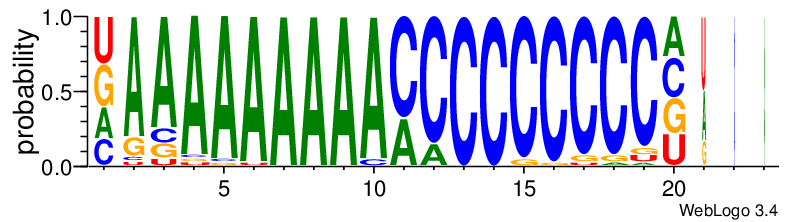

Cluster id:3


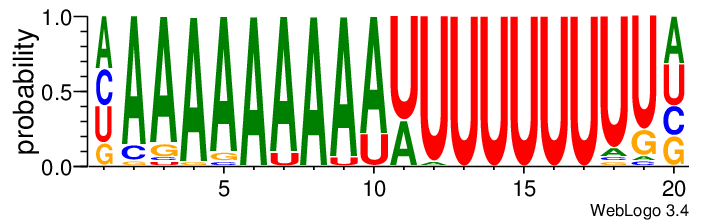

In [162]:
from utilities import MuscleAlign_wrapper, Weblogo
from IPython.display import Image, display
from utilities import PWM

for cluster_id in seqmot.motives_db:
    print 'Cluster id:%d' % cluster_id
    ma = MuscleAlign_wrapper()
    cluster_seqs = [(i,motif) for i, (count, motif) in enumerate(seqmot.motives_db[cluster_id])]
    aligned_cluster_seqs = ma.transform(seqs=cluster_seqs)
    # for h,s in aligned_cluster_seqs: print s
    wb = Weblogo(output_format='png', sequence_type = 'rna', resolution=200, stacks_per_line=40, units='probability')
    logo_image = wb.create_logo(seqs=aligned_cluster_seqs)
    display(Image(logo_image))

find a way to re-evaluate each sequence in a cluster according to the alignment and filter out the bad ones

---